# Basic Text Classification

https://www.tensorflow.org/tutorials/keras/text_classification


In [3]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses

2023-09-15 10:45:20.278082: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
print(tf.__version__)

2.13.0


In [5]:
# 50k reviews; 25k train 25k test
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

ds = tf.keras.utils.get_file("aclImdb_v1", url, untar=True, cache_dir="./cache", cache_subdir='')
ds_dir = os.path.join(os.path.dirname(ds), 'aclImdb')


In [6]:
print(os.listdir(ds_dir))

tr_dir = os.path.join(ds_dir, 'train')

print(os.listdir(tr_dir))

sample_file = os.path.join(tr_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())

['.DS_Store', 'imdbEr.txt', 'test', 'imdb.vocab', 'README', 'train']
['urls_unsup.txt', '.DS_Store', 'neg', 'urls_pos.txt', 'unsup', 'urls_neg.txt', 'pos', 'unsupBow.feat', 'labeledBow.feat']
Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


In [7]:

remove_dir = os.path.join(tr_dir, 'unsup')
shutil.rmtree(remove_dir)

In [8]:
# tf.data 
batch_size = 32
seed = 42

# dataset: train, validate, test
raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    os.path.join(ds_dir,'train'),
    batch_size=batch_size,
    validation_split=0.2,
    subset="training",
    # When using the validation_split and subset arguments, make sure to either specify a random seed, 
    # or to pass shuffle=False, so that the validation and training splits have no overlap.
    seed=seed
)
print("")
print("Classes: ", raw_train_ds.class_names)
print("")
raw_validation_ds = tf.keras.utils.text_dataset_from_directory(
    os.path.join(ds_dir,'train'),
    batch_size=batch_size,
    validation_split=0.2,
    subset="validation",
    # When using the validation_split and subset arguments, make sure to either specify a random seed, 
    # or to pass shuffle=False, so that the validation and training splits have no overlap.
    seed=seed
)
print("")
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    os.path.join(ds_dir, 'test'),
    batch_size=batch_size
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.

Classes:  ['neg', 'pos']

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.

Found 25000 files belonging to 2 classes.


In [9]:
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(3):
        print(f"Label: {raw_train_ds.class_names[label_batch.numpy()[i]]}")
        print(f"Text: {text_batch.numpy()[i]}")
        print("")

Label: neg
Text: b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'

Label: neg
Text: b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as t

In [10]:
# tf.keras.layers.TextVectorization
#   standardize   - preprocess text; remove punctuation, html, etc. to simplify the DS
#   tokenize      - splitting strigns into tokens (#split(" "))
#   vectorize     - converting tokens to numbers so they can be fed into a NN

def simple_standardize(input_data):
    lowercased = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercased, '<br />', ' ')
    punctuation = tf.strings.regex_replace(stripped_html, '[%s]' % re.escape(string.punctuation), '')

    return punctuation

max_tokens = 10000
output_sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=simple_standardize,
    max_tokens=max_tokens,
    output_mode="int", # unique integer index for each token (ie. word)
    output_sequence_length=output_sequence_length # layer will pad or truncate text to this length
)

In [128]:
# Make a text-only dataset (no labels), then #adapt to fit the state of the preprocessing layer to the dataset.
# this causes the model to build an index of strings to integers
train_text = raw_train_ds.map(lambda x, _y: x)
vectorize_layer.adapt(train_text)

def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [130]:
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]

print("Review", first_review)
print("RR",  vectorize_layer(tf.expand_dims(first_review, -1)))
print("Label", raw_train_ds.class_names[first_label])
vt = vectorize_text(first_review, first_label)
# print("vectorized sentence", " ".join([str(x) for x in vt[0].numpy()]))
print("4 ---> ",vectorize_layer.get_vocabulary()[4])
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))
print("Vectorized review", vt)

Review tf.Tensor(b'"Emma" was a product of what might be called by the First Great Jane Austen Cycle of the mid-nineties, and it was recently shown on British television, doubtless because of the interest in the author created by the Second Great Jane Austen Cycle which started with "Pride and Prejudice" two years ago. We currently have in the cinemas the Austen biopic "Becoming Jane", and ITV have recently produced three TV movies based on Austen novels. These include "Northanger Abbey", the only one of the six major novels not to have been filmed previously, so the cycle should now be complete. No doubt, however, there will be more to come in the near future. (There is, after all, her juvenile "Love and Freindship" (sic), the short novella "Lady Susan", and someone, somewhere, has doubtless supplied endings to her two unfinished fragments "The Watsons" and "Sanditon". Then there are all those Austen sequels churned out by modern writers\xc2\x85\xc2\x85\xc2\x85).<br /><br />The main c

In [13]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_validation_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# NN model


In [48]:
# he Embedding layer can be understood as a lookup table that maps from integer indices (which stand for specific words) to dense vectors (their embeddings).
# The dimensionality (or width) of the embedding is a parameter you can experiment with to see what works well for your problem, much in the same way you would 
# experiment with the number of neurons in a Dense layer.
emedding_dim = 16

model = tf.keras.Sequential([
    layers.Embedding(max_tokens + 1, emedding_dim),
    # why did they add 1??
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    # returns a fixed-length output vector for each example by averaging over the sequence dimension.
    # This allows the model to handle input of variable length, in the simplest way possible.
    layers.Dropout(0.2),
    layers.Dense(1)
]) # output array (batch, sequence, embedding)
model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   


 embedding_4 (Embedding)     (None, None, 16)          160016    
                                                                 
 dropout_8 (Dropout)         (None, None, 16)          0         
                                                                 
 global_average_pooling1d_4  (None, 16)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_9 (Dropout)         (None, 16)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 160033 (625.13 KB)
Trainable params: 160033 (625.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [52]:
model.compile(
    loss=losses.BinaryCrossentropy(from_logits=True),
    optimizer='adam', #
    metrics=tf.metrics.BinaryAccuracy(threshold=0.0)
)

callbacks = [
  tf.keras.callbacks.EarlyStopping(monitor="loss", patience=2, verbose=1, min_delta=0.01, mode="min"),
]

epochs = 10
fit_history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=callbacks)


Epoch 1/10
625/625 [==============================] - 6s 8ms/step - loss: 0.2182 - binary_accuracy: 0.9212 - val_loss: 0.2887 - val_binary_accuracy: 0.8808
Epoch 2/10
625/625 [==============================] - 5s 7ms/step - loss: 0.2057 - binary_accuracy: 0.9262 - val_loss: 0.2872 - val_binary_accuracy: 0.8814
Epoch 3/10
625/625 [==============================] - 6s 10ms/step - loss: 0.1970 - binary_accuracy: 0.9299 - val_loss: 0.2866 - val_binary_accuracy: 0.8814
Epoch 4/10
625/625 [==============================] - 4s 7ms/step - loss: 0.1866 - binary_accuracy: 0.9334 - val_loss: 0.2869 - val_binary_accuracy: 0.8822
Epoch 5/10
625/625 [==============================] - 4s 7ms/step - loss: 0.1775 - binary_accuracy: 0.9379 - val_loss: 0.2876 - val_binary_accuracy: 0.8844
Epoch 6/10
625/625 [==============================] - 4s 6ms/step - loss: 0.1702 - binary_accuracy: 0.9403 - val_loss: 0.2894 - val_binary_accuracy: 0.8846
Epoch 7/10
625/625 [==============================] - 4s 7ms/st

In [51]:
loss, accuracy = model.evaluate(test_ds)


  1/782 [..............................] - ETA: 5s - loss: 0.1863 - binary_accuracy: 0.9688

782/782 [==============================] - 1s 1ms/step - loss: 0.3105 - binary_accuracy: 0.8730


dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


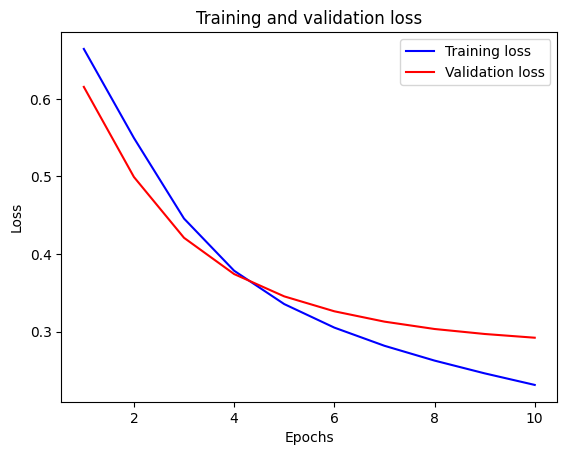

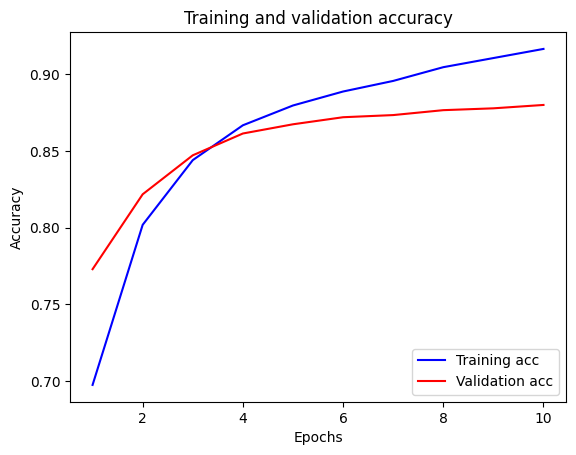

In [50]:
h_dict = fit_history.history
print(h_dict.keys())

acc = h_dict['binary_accuracy']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, h_dict['loss'], 'b', label='Training loss')
# b is for "solid blue line", r is for "solid red line"
plt.plot(epochs, h_dict['val_loss'], 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, h_dict['val_binary_accuracy'], 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()


In [53]:
export_model = tf.keras.Sequential([
    vectorize_layer,
    model,
    layers.Activation('sigmoid')
])
export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=True),
    optimizer="adam",
    metrics=['accuracy']
)
loss, accuracy = export_model.evaluate(raw_test_ds)
print(loss, accuracy)

  1/782 [..............................] - ETA: 3:01 - loss: 0.1481 - accuracy: 0.9375

/usr/local/lib/python3.11/site-packages/keras/src/backend.py:5805: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


782/782 [==============================] - 4s 4ms/step - loss: 0.3345 - accuracy: 0.8682
0.334505558013916 0.8682000041007996


In [59]:
export_model.predict(['This movie was terrible. The acting was like a bunch of kids who have never had any training before. puke blah!',
                      'This was great',
                      'this was shit',
                      'this was the shit',
                      'this was damn good shit',
                      'this was fucking shit'])

1/1 [==============================] - 0s 59ms/step


array([[0.09608951],
       [0.6431425 ],
       [0.5011153 ],
       [0.5072838 ],
       [0.6187622 ],
       [0.49765447]], dtype=float32)

In [106]:
# export the model

model.save('./lesson_3_model')
# model.save_weights('./lesson_3_weights')
# mode.load_weights('./lesson_3_weights')


INFO:tensorflow:Assets written to: ./lesson_3_model/assets


INFO:tensorflow:Assets written to: ./lesson_3_model/assets


In [ ]:
import json
json_config = model.to_json()
# model = tf.keras.models.model_from_json(json_config)
js = json.loads(json_config)

def pd(d, i=0):
  for key in d.keys():
    print(key)
    print('-' * (2+i), d[key])
    if isinstance(d[key], dict):
      pd(d[key], i+1)
    if isinstance(d[key], list):
      print(d[key][0].keys())
      for val in d[key]:
        print(val)

pd(js)

In [107]:
loaded_model = tf.keras.models.load_model('./lesson_3_model') 

In [113]:
export_model = tf.keras.Sequential([
    vectorize_layer,
    loaded_model,
    layers.Activation('sigmoid')
])
export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=True),
    optimizer="adam",
    metrics=['accuracy']
)

In [135]:
# loss, accuracy = export_model.evaluate(raw_test_ds)



def vectorize_text_simple(txt):
    txt = tf.expand_dims(txt, -1)
    return vectorize_layer.adapt(txt)

# txt = vectorize_text_simple('this is the best movie ever')
# print(txt)
# txt.get_vocabulary()
# loaded_model.predict([vectorize_text_simple('this is the best movie ever')])
export_model.predict(['this is the best movie ever'])[0][0]


1/1 [==============================] - 0s 60ms/step


0.4810632